# Comic Book Cancellations

While some Marvel comic books run for decades, most series go through cycles. For example, [Charles Soule's *She-Hulk* (2014)](https://www.cbr.com/charles-soule-investigates-she-hulks-blue-file/) was a colorful and quirky crime serial that got cancelled on its 12th issue. However, that was not the end of the titular character. A year after that series cancellation, she reappeared in [Mario Tamaki's *Hulk* (2016)](https://www.cbr.com/hulk-1-gives-marvel-an-unstable-dangerous-jennifer-walters/) which was far more introspective and focused on her pain and depression following the murder of her cousin. While these legacy characters may eventually be picked up again in another book, the tone, style, and genre of their stories often change with the new creative team.

So what causes so many of my favorite stories to get cancelled seemingly ahead of their time? Some books end at the author's request because the story has reached its conclusion. When *Young Avengers* (2013) was cancelled, the author Kieron Gillen [stated](http://kierongillen.tumblr.com/post/66995678192/young-avengers-the-end-of-the-season), "When the time came around and Marvel asked if we wanted to do more issues, Jamie and I decided we’d actually made our statement, and should leave the stage." However, most Marvel comics are written as serials without the intention of including a final on-going conclusion. Instead, as Marvel Executive Editor Tom Brevoort [stated](https://twitter.com/TomBrevoort/status/945861802813984768) in 2017 amidst a string of cancellations, "We go through this cycle every year where weaker-selling titles get pruned".

So are books that get cancelled actually weaker selling? And if so, what criteria determines cancellation? Of that [string](https://www.cbr.com/marvel-cancels-generation-x-gwenpool-more/) [of](https://www.cbr.com/marvel-comics-cancels-iceman-luke-cage/) [cancellations](https://www.cbr.com/marvel-comics-cancels-she-hulk/) in early 2017, all of the series had female, queer, or colored leads. This naturally poses the question of whether the cancellations are the result of new characters introduced through Marvel's diversity initatives not selling as well as long-established legacy characters or Marvel caving to [retailers](https://www.cbr.com/marvel-sales-diversity/) who feel like "people didn't want any more diversity". 

To answer these questions, I'll use machine learning in order to develop a cancellation criteria based on comic book sales data. This first part will focus on web scrapping publically available comic book sales data and developing a SQL database to store that data in SQLite. The second part will parse through that data and implement machine learning algorithsms on that data to determine the criteria for cancellation.

## 1. Web Scrapping


### Imports

In [178]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from scipy.optimize import curve_fit

%matplotlib inline

### Web Scrapping

The majority of comic books are distributed to comic book stores through Diamond Comic Distributors. Data for monthly sales is freely available from [Comichron](http://www.comichron.com/monthlycomicssales.html) for every month since 1998. This data provides a good estimate of single issue sales through comic books stores but not for digital comic sales through [Comixology](https://www.comixology.com/) or collected edition sales. 

In order to scrape the data, I'll be using the Python [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup) package. It will then be saved into a [SQLite](https://sqlite.org/index.html) database which can take several minutes to finish. The final database can be found [here](./sales.db).

In [282]:
# download_comic_sales return a DataFrame contains comic sales from Comichron for the given month and year
def download_comic_sales(month, year):
    url = "http://www.comichron.com/monthlycomicssales/{1}/{1}-{0:02}.html".format(month, year)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    table = soup.find('table', id = "Top300Comics")
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all(['td', 'th'])
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols])
    comics_table = pd.DataFrame(data[1:], columns=data[0])
    
    comics_table.drop(columns = "On sale", inplace = True, errors = 'ignore')
    comics_table.rename(columns={comics_table.columns[0]: "UnitRank", comics_table.columns[1]: "DollarRank"}, inplace=True)
    comics_table.drop('UnitRank', 1, inplace=True)
    comics_table.drop('DollarRank', 1, inplace=True)
    comics_table.rename(columns={'Comic-book Title' : 'Title', 'Est. units' : 'Units'}, inplace=True)
    comics_table['Issue'] = comics_table['Issue'].map(lambda x: re.findall('\d+\.?\d*', x)[0] if len(re.findall('\d+\.?\d*', x)) >= 1 else '')
    comics_table['Issue'] = pd.to_numeric(comics_table['Issue'], errors='coerce')
    comics_table["Title"] = comics_table["Title"].replace("†", "", regex=True)
    comics_table["Price"] = comics_table["Price"].replace("\$", "", regex=True).astype(float)
    comics_table['Units'] = comics_table['Units'].replace(',', '', regex=True).astype(int)
    comics_table['Gross'] = comics_table['Units']*comics_table['Price']
    comics_table['Date'] = pd.to_datetime('{}{:02}'.format(year, month), format='%Y%m', errors='ignore')
    comics_table = comics_table.dropna(axis='rows')
    return(comics_table)

# Loop through every month since 1998 adding data to SQLite database
db = sqlite3.connect('sales.db')
for year in range(1998, 2018):
    for month in range(1, 13):
        df = download_comic_sales(month, year)
        df.to_sql("sales", db, if_exists="append")
for year in range(2018, 2019):
    for month in range(1, 6):
        df = download_comic_sales(month, year)
        df.to_sql("sales", db, if_exists="append")
db.close()

## 2. Data Cleaning

The database information is mostly consistent, but there are a few things I can clean up. 
- Only keep Marvel comics
- Distinguish between multiple runs of the comic with separate \#1 issues
- Aggregate sales information for unique comics (same Title, Starting Year, Issue #)
- Remove .1 issues which are special jumping on points separate from main continuity
- Remove obvious marketing gimmick issues
- Rename some titles so that they're consistent.

Since 1998, many titles have restarted with new \#1 issues. To separate multiple runs with the title, each issue is uniquely described by its title and it's run's starting year. Additionally, some popular issues may be sold multiple months in a row so titles need to be aggregated together if they have the same title, series starting year, and issue number. I've also added two more features for the series' largest issue number and whether the title is being currently being published.

In [625]:
db = sqlite3.connect('sales.db')

# Load web scrapped data from SQL database for Marvel comics
df = pd.read_sql_query('''
SELECT Title, Issue, Price, Units, Gross, Date
FROM sales
WHERE Publisher = "Marvel" 
''', db, parse_dates=['Date'])
db.close()

# Rename titles for consistency and remove extraneous issue
df = df[(df.Issue % 1 == 0) & (df.Issue != 0) & (df.Issue < 900)]
df.loc[df.Title == 'Us Avengers', 'Title'] = "U.S. Avengers"
df.loc[df.Title == 'US Avengers', 'Title'] = "U.S. Avengers"
df.loc[df.Title == 'U.S.Avengers', 'Title'] = "U.S. Avengers"
df.loc[df.Title == 'Avengers Ai', 'Title'] = "Avengers AI"
df.loc[df.Title == 'All New Guardians of Galaxy', 'Title'] = "All New Guardians of the Galaxy"
df.loc[df.Title == 'Marvel Universe Ult Spider-Man Web Warriors', 'Title'] = "Marvel Universe Ultimate Spider-Man Web Warriors"
df.loc[df.Title == 'Kanan The Last Padawan', 'Title'] = "Kanan"
df.loc[df.Title == 'Kanan Last Padawan', 'Title'] = "Kanan"
df.loc[df.Title == 'Star Wars Kanan', 'Title'] = "Kanan"

# Develop table with each series information (Title, StartYear, StartDate)
series_df = df[df['Issue'] == 1].groupby(['Date', 'Title']).agg({'Title':'first', 'Date': 'first'})
series_df['StartYear'] = series_df['Date'].map(lambda x: x.year)
series_df.reset_index(drop=True, inplace=True)
series_df.sort_values(by=['Title', 'Date'], inplace=True)
series_df.reset_index(drop=True, inplace=True)
series_df2 = pd.DataFrame()
series_df2 = series_df2.append(series_df.iloc[0])
for i in range(series_df.shape[0]-1):
    if (series_df.Title[i+1] != series_df.Title[i]) or (series_df.Date[i+1] - series_df.Date[i] > pd.Timedelta(3, unit='M')):
        series_df2 = series_df2.append(series_df.iloc[i+1])
series_df = series_df2

# Use series table to determine StartYear for each entry in database
df['StartYear'] = pd.Series()
for i in range(df.shape[0]):
    title = df.iloc[i].Title
    date = df.iloc[i].Date
    s = series_df[(series_df.Title == title) & (series_df.Date <= date)].sort_values(by='Date', ascending=False)
    if s.shape[0] > 0:
        df.loc[df.index[i], 'StartYear'] = s.iloc[0].StartYear

# Remove titles that don't have #1 issues in the data set or other missing data
df = df.dropna(axis='rows')

# Sum sales issue for each unique issue (unique Title, StartYear, Issue #)
df = df.groupby(['Title', 'Issue', 'StartYear']).agg({'Title' : 'first', 'StartYear' : 'first', 'Issue': 'first', 'Date' : 'min', 'Price' : 'first', 'Units' : 'sum', 'Gross' : 'sum' })
df.reset_index(drop=True, inplace=True)

# Add new features for the title's maximum issue and whether it is a current title
df2 = pd.pivot_table(df, values='Issue', index=['Title', 'StartYear'], aggfunc=np.max).rename(columns={'Issue':'MaxIssue'})
df = pd.merge(left=df, right=df2, on=['Title', 'StartYear'], sort=False).sort_values(by='Units', ascending=False)
max_date = df['Date'].max()
df2 = pd.pivot_table(df, values='Date', index=['Title', 'StartYear'], aggfunc=lambda x: max(x) == max_date).rename(columns={'Date':'CurrentTitle'})
df = pd.merge(left=df, right=df2, on=['Title', 'StartYear'], sort=False).sort_values(by='Units', ascending=False)

We can see what our data looks like by peeking into the first few rows of the table.

In [619]:
df.head(3)

,Title,StartYear,Issue,Date,Price,Units,Gross,MaxIssue,CurrentTitle
0,Star Wars,2015.0,1.0,2015-01-01,4.99,1070357,5341081.43,39.0,False
39,FCBD Edition Ultimate Spider-Man,2002.0,1.0,2002-04-01,0.12,631990,75838.80,1.0,False
40,Amazing Spider-Man,2014.0,1.0,2014-04-01,5.99,556457,3333177.43,18.0,False


### Preliminary Analysis - Cancellation Issue

Now we can look at what issue is often the last issue before cancellation.

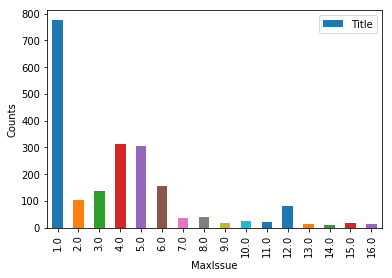

In [620]:
pd.pivot_table(df, values=['Title'], index='MaxIssue', aggfunc={'Title':lambda x: len(x.unique())}).iloc[0:16].plot(kind='bar', y='Title')
plt.ylabel('Counts')
plt.show()

Based on length, Marvel comics appear to fall into several categories: (1) one-shots, (2) events and mini-series that run less than 6 issues, (3) ongoing titles that are immediately cancelled around 12 issues, and (4) ongoing titles that continue past 12 issues.

Our interest is in titles that were specificaly cancelled not titles that were always intended to have a short run (one-shots or mini-series) or titles that may have restarted wtih a new \#1 or changed their title for marketing purposes. I have no way of determining how each series ended without manually going through each title and looking into them which would be a time-consuming process. For now, I'm going to overly restrict my data and only compare titles that got cancelled on their 12 issue with titles that lasted longer than 12 issues. Becuase 12 issues is a standard length at which comics get dropped, this should allow me to see what threshold is being used for cancellation.


## Feature Labelling - Cancellation

Titles that prematurely finished with 12 issues will be labeled as "Cancelled" whereas books that last longer than that will be labelled as "Kept". I'm then going to aggregate my data by title, keeping features for the unit sales and gross profits for the first 12 months as well as the book's maximum issue and whether it's a current title.

In [628]:
# Removed 'Avengers Vs. X-Men' because it is an event comic that lasted 12 issues and was not cancelled per se
df.drop(df.index[df.Title == 'Avengers Vs X-Men'], inplace=True)

# Select cancelled titles that start with an issue #1 and finish with their 12th issue.  Group by title and create features for units and gross sales for first 12 months.
dfUnits = df.loc[(df.Issue == 1) & (df.MaxIssue == 12), ['Title', 'StartYear']].reset_index(drop=True)
for i in range(1,13):
    dfUnits = pd.merge(left=dfUnits, right=df.loc[(df.Issue == i) & (df.MaxIssue == 12), ['Title', 'StartYear', 'Units']].rename(columns={'Units': 'Units' + str(i)}), on=['Title', 'StartYear'])
dfUnits = dfUnits.dropna(axis='rows')
dfGross = df.loc[(df.Issue == 1) & (df.MaxIssue == 12), ['Title', 'StartYear']].groupby(['Title', 'StartYear']).first().reset_index()
for i in range(1,13):
    dfGross = pd.merge(left=dfGross, right=df.loc[(df.Issue == i) & (df.MaxIssue == 12), ['Title', 'StartYear', 'Gross']].rename(columns={'Gross': 'Gross' + str(i)}), on=['Title', 'StartYear'])
dfGross = dfGross.dropna(axis='rows')
df1 = pd.merge(left=dfUnits, right=dfGross, on=['Title', 'StartYear'])
df2 = df[['Title', 'StartYear', 'MaxIssue', 'CurrentTitle']]
df2 = df2.groupby(['Title', 'StartYear']).agg({'MaxIssue':'first',
                         'CurrentTitle':'first'}).reset_index()
dfCancelled = pd.merge(left=df1, right=df2, on=['Title', 'StartYear'])
dfCancelled['Kept'] = 0

# Select kept titles that start with an issue #1 and then continue past their 12th issue. Group by title and create features for units and gross sales for first 12 months.
dfUnits = df.loc[(df.MaxIssue > 12) & (df.Issue == 1), ['Title', 'StartYear']].reset_index(drop=True)
for i in range(1,13):
    dfUnits = pd.merge(left=dfUnits, right=df.loc[(df.Issue == i) & (df.MaxIssue > 12), ['Title', 'StartYear', 'Units']].rename(columns={'Units': 'Units' + str(i)}), on=['Title', 'StartYear'])
dfUnits = dfUnits.dropna(axis='rows')
dfGross = df.loc[(df.MaxIssue > 12) & (df.Issue == 1 | (df.Issue == 12)), ['Title', 'StartYear']].groupby(['Title', 'StartYear']).first().reset_index()
for i in range(1,13):
    dfGross = pd.merge(left=dfGross, right=df.loc[(df.Issue == i) & (df.MaxIssue > 12), ['Title', 'StartYear', 'Gross']].rename(columns={'Gross': 'Gross' + str(i)}), on=['Title', 'StartYear'])
dfGross = dfGross.dropna(axis='rows')
df1 = pd.merge(left=dfUnits, right=dfGross, on=['Title', 'StartYear'])
df2 = df.loc[(df['Issue'] <= 12),['Title', 'StartYear', 'MaxIssue', 'CurrentTitle']]
df2 = df2.groupby(['Title', 'StartYear']).agg({'MaxIssue':'first',
                         'CurrentTitle':'first'}).reset_index()
dfKept = pd.merge(left=df1, right=df2, on=['Title', 'StartYear'])
dfKept['Kept'] = 1

# Combine both Cancelled and Kept titles
df = pd.concat([dfCancelled, dfKept], ignore_index=True, sort=False)

Peering into the first few rows shows that we now have sales information (units and gross) for the first 12 months of sales of new titles.

In [538]:
df.head(3)

,Title,Issue,Price,Units,Gross,Date,StartYear,MaxIssue,CurrentTitle
0,Star Wars,1.0,4.99,985976,4920020.24,2015-01-01,2015.0,48.0,True
62,FCBD Edition Ultimate Spider-Man,1.0,0.12,631990,75838.80,2002-04-01,2002.0,1.0,False
63,Amazing Spider-Man,1.0,5.99,532586,3190190.14,2014-04-01,1998.0,800.0,True


## 3. Feature Engineering - Exponential Fitting

Monthly unit sales and gross profit uncannily follow an exponential decay over the course of the first several months. People try new titles for the first several issues to decide whether they like the book. Thenw ithin the first few months, they decide whether to drop the book orcontinue to follow it. After that point, sales tend stay relatively consistent.

In addition to my monthly unit sales, I'm going to engineer some new features based on the exponential fit parameters. These features allow for the entire trend of the sales information with time to be captured in just a few variables.

#### Exponential Models:
$Units(x) = (UI-UF) exp(-(x-1)(UT)) + UF$

$UI$ = Initial Sales <br />
$UT$ = Exponential Time Decay Constant <br />
$UF$ = Asymptotic Final Sales

$Gross(x) = (GI-GF) exp(-(x-1)(GT)) + GF$

$GI$ = Initial Gross Profit <br />
$GT$ = Exponential Time Decay Constant <br />
$GF$ = Asymptotic Final Gross Profit

The exponential fit doesn't describe all the titles. For example, some of them have a linear change in sales without a first issue spike which would most likely happen if the series gets a new \#1 without a real change in direction or creative team. However, for most titles the exponential fit describes the trend of the sales curve without the variance of the montly sales numbers. 

In [640]:
r = 10 # Number of issues starting from beginning to include in fit
x = np.arange(r)
def exponenial_func(x, I, T, F):
    return (I-F)*np.exp(-x/T)+F

UI_list = np.array([])
UT_list = np.array([])
UF_list = np.array([])

for i in range(df.shape[0]):
    y = df.iloc[i, 2:2+r].astype(float).values
    popt, pcov = curve_fit(exponenial_func, x, y, p0=(100000, 1, 20000))
    UI_list = np.append(UI_list, popt[0])
    UT_list = np.append(UT_list, popt[1])
    UF_list = np.append(UF_list, popt[2])
    # List titles that don't fit
    if pcov[0,0] == float('Inf'):
        print('Trouble Fitting Units for', df.iloc[i]['Title'])

GI_list = np.array([])
GT_list = np.array([])
GF_list = np.array([])

for i in range(df.shape[0]):
    y = df.iloc[i, 14:14+r].astype(float).values
    popt, pcov = curve_fit(exponenial_func, x, y, p0=(60000, 0.5, 20000))
    GI_list = np.append(GI_list, popt[0])
    GT_list = np.append(GT_list, popt[1])
    GF_list = np.append(GF_list, popt[2])
    # List titles that don't fit
    if pcov[0,0] == float('Inf'):
        print('Trouble fitting Gross for', df.iloc[i]['Title'])        

df['UI'] = UI_list
df['UT'] = UT_list
df['UF'] = UF_list
df['GI'] = GI_list
df['GT'] = GT_list
df['GF'] = GF_list

C:\Users\Christopher\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Trouble Fitting Units for New Avengers
Trouble Fitting Units for Astonishing X-Men
Trouble Fitting Units for Ultimate X-Men
Trouble Fitting Units for Ms Marvel
Trouble Fitting Units for X-Factor
Trouble Fitting Units for She-Hulk 2
Trouble fitting Gross for Inhumans
Trouble fitting Gross for Star Wars
Trouble fitting Gross for Astonishing X-Men
Trouble fitting Gross for Hulk
Trouble fitting Gross for Ultimate X-Men
Trouble fitting Gross for Ms Marvel
Trouble fitting Gross for X-Factor
Trouble fitting Gross for Captain Marvel
Trouble fitting Gross for She-Hulk 2


### Checking Fits

We confirm how well the fit works by comparing it with the actual sales for a title.

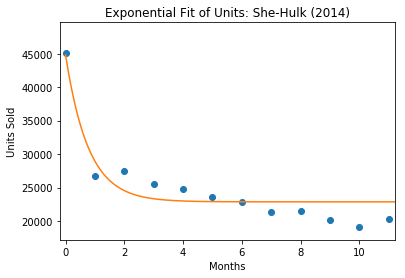

In [658]:
title = 'She-Hulk'
start_year = 2014
df2 = df[(df.Title == title) & (df.StartYear == start_year)]

# Monthly Sales Values
x = np.arange(12)
y = df2.iloc[0,2:2+12].astype(float).values

#Exponential Fit Values
def exponenial_func(x, I, T, F):
    return (I-F)*np.exp(-x/T)+F

xx = np.linspace(0, 12, 1000)
yy = exponenial_func(xx, df2.UI[0], df2.UT[0], df2.UF[0])

# Plot
ymin = min(y); ymax = max(y)
plt.plot(x,y,'o', xx, yy)
plt.title('Exponential Fit of Units: {} ({})'.format(title, start_year))
plt.xlim([-0.2,11.2])
plt.ylim([0.9*ymin, 1.1*ymax])
plt.ylabel('Units Sold')
plt.xlabel('Months')
plt.show()

## 4. Save Databse

In [662]:
df = df.reset_index(drop=True)
db = sqlite3.connect('sales.db')
df.to_sql("marvel_sales", db, if_exists="replace")
db.close()

In this first part, we've scrapped comic book sales data, cleaned up some of irregularities in issue numbers and title names, aggregated the data into unique runs by the title's name and starting year, classified titles based on whether they were **kept** or **cancelled** after 12 months, and engineered new features based on the regression fit of the sales data to an exponential decay curve.

Now, we have the data and it is ready to be processed by machine learning algorithms in order to determine the cancellation criteria which will be demonstrated in part 2.